In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split
from torch.nn import functional as F

import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd

import cv2
import os


In [2]:
class ConcatenatedDataset(Dataset):
    def __init__(
        self,
        annotations_file,
        img_dir,
        transform_positives=None,
        transform_background=None,
        target_transform=None,
    ):
        self.img_labels = pd.read_csv(annotations_file, header=None)
        self.img_dir = img_dir
        self.transform_positives = transform_positives
        self.transform_background = transform_background
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # image = Image.open(img_path)
        image = cv2.imread(img_path)

        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.img_labels.iloc[idx, 1]
        if label == 0 and self.transform_background:
            image = self.transform_background(image=image)["image"]
        if label != 0 and self.transform_positives:
            image = self.transform_positives(image=image)["image"]
        # if self.transform:
        #     image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


In [3]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
transform = A.Compose(
    [
        # A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.RandomCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, always_apply=True),
        A.Rotate(limit=35, p=1.0),
        A.ToGray(always_apply=True),
        A.Normalize(),
        ToTensorV2(),
    ]
)
whole_dataset = ConcatenatedDataset(
    annotations_file="imgs_merged/labels.csv",
    img_dir="imgs_merged",
    transform_background=transform,
    transform_positives=transform,
)


In [4]:
class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel (black & white), 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = torch.nn.Conv2d(3, 6, 5)
        self.drop1 = nn.Dropout2d(p=0.5)
        self.conv2 = torch.nn.Conv2d(6, 16, 3)
        self.drop1 = nn.Dropout2d(p=0.5)

        # an affine operation: y = Wx + b
        self.fc1 = torch.nn.LazyLinear(120)  # 6*6 from image dimension
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 3)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))

        x = F.relu(self.fc2(x))

        x = self.fc3(x)

        return x


In [5]:
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    train_loss, train_correct = 0.0, 0
    model.train()
    for images, labels in dataloader:

        images, labels = images.to(device), labels.to(device)
        images = images.float()
        optimizer.zero_grad()

        output = model(images)

        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss, train_correct


def valid_epoch(model, device, dataloader, loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:

        images, labels = images.to(device), labels.to(device)
        images = images.float()
        output = model(images)
        loss = loss_fn(output, labels)
        valid_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        val_correct += (predictions == labels).sum().item()

    return valid_loss, val_correct


In [6]:
df = whole_dataset.img_labels
train_ind, test_ind = train_test_split(df, stratify=df[1], test_size=0.2)


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
criterion = nn.CrossEntropyLoss()

dataset = whole_dataset

num_epochs = 20
batch_size = 100


In [8]:
train_sampler = SubsetRandomSampler(train_ind.index.to_numpy())
test_sampler = SubsetRandomSampler(test_ind.index.to_numpy())
train_loader = DataLoader(whole_dataset, sampler=train_sampler, batch_size=batch_size)
test_loader = DataLoader(whole_dataset, sampler=test_sampler, batch_size=batch_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = LeNet()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002)

history = {"train_loss": [], "test_loss": [], "train_acc": [], "test_acc": []}

for epoch in range(num_epochs):
    train_loss, train_correct = train_epoch(
        model, device, train_loader, criterion, optimizer
    )
    test_loss, test_correct = valid_epoch(model, device, test_loader, criterion)

    train_loss = train_loss / len(train_loader.sampler)
    train_acc = train_correct / len(train_loader.sampler) * 100
    test_loss = test_loss / len(test_loader.sampler)
    test_acc = test_correct / len(test_loader.sampler) * 100

    print(
        "Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(
            epoch + 1, num_epochs, train_loss, test_loss, train_acc, test_acc
        )
    )
    history["train_loss"].append(train_loss)
    history["test_loss"].append(test_loss)
    history["train_acc"].append(train_acc)
    history["test_acc"].append(test_acc)


/Users/piotr/Documents/studia/SEM6/TWM/road-markings-detection/.venv/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch:1/20 AVG Training Loss:1.114 AVG Test Loss:1.318 AVG Training Acc 22.39 % AVG Test Acc 47.06 %
Epoch:2/20 AVG Training Loss:1.376 AVG Test Loss:4.156 AVG Training Acc 44.78 % AVG Test Acc 47.06 %
Epoch:3/20 AVG Training Loss:3.971 AVG Test Loss:0.725 AVG Training Acc 41.79 % AVG Test Acc 58.82 %
Epoch:4/20 AVG Training Loss:0.660 AVG Test Loss:0.843 AVG Training Acc 56.72 % AVG Test Acc 76.47 %
Epoch:5/20 AVG Training Loss:0.740 AVG Test Loss:1.229 AVG Training Acc 77.61 % AVG Test Acc 76.47 %
Epoch:6/20 AVG Training Loss:1.063 AVG Test Loss:0.993 AVG Training Acc 77.61 % AVG Test Acc 76.47 %
Epoch:7/20 AVG Training Loss:0.835 AVG Test Loss:0.266 AVG Training Acc 77.61 % AVG Test Acc 82.35 %
Epoch:8/20 AVG Training Loss:0.424 AVG Test Loss:0.216 AVG Training Acc 80.60 % AVG Test Acc 82.35 %
Epoch:9/20 AVG Training Loss:0.207 AVG Test Loss:0.090 AVG Training Acc 88.06 % AVG Test Acc 100.00 %
Epoch:10/20 AVG Training Loss:0.196 AVG Test Loss:0.176 AVG Training Acc 97.01 % AVG Test 

In [9]:
classes = ("T-shirt/top", "Trouser", "Pullover")


def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


def images_to_probs(net, images):
    """
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    """
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    """
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    """
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx + 1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title(
            "{0}, {1:.1f}%\n(label: {2})".format(
                classes[preds[idx]], probs[idx] * 100.0, classes[labels[idx]]
            ),
            color=("green" if preds[idx] == labels[idx].item() else "red"),
        )
    return fig


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


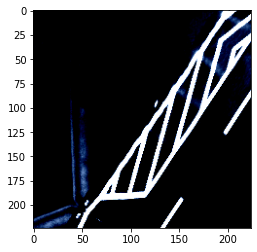

In [10]:
matplotlib_imshow(dataset[10][0])

# dataset[0][0]